# AI Model for Predicting Sea Surface Currents 

This notebook outlines the steps to develop a CNN-LSTM hybrid model for predicting future sea surface currents.

### Importing necessary libraries

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, 
    BatchNormalization, Reshape)
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tqdm.keras import TqdmCallback

### Printing info about Sea Surace Currents Dataset

In [2]:
# Load the processed sea surface current (SSC) data
ssc_data_path = "Data/Processed_SSC_Data.nc"
ssc_ds = xr.open_dataset(ssc_data_path)

# Display the dataset structure
print(ssc_ds)
print("="*125)

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 22, time: 2091)
Coordinates:
  * lat      (lat) float32 35.74 35.77 35.79 35.81 ... 36.21 36.23 36.26 36.28
  * lon      (lon) float32 13.92 13.96 14.0 14.04 ... 14.65 14.69 14.73 14.77
  * time     (time) datetime64[ns] 2021-01-01 2021-01-01T12:00:00 ... 2023-11-12
Data variables:
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...
    stdu     (time, lat, lon) float64 ...
    stdv     (time, lat, lon) float64 ...
    cov      (time, lat, lon) float64 ...
    velo     (time, lat, lon) float64 ...
    head     (time, lat, lon) float64 ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  BARK (measured);POZZ (measured);
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 14:46:23
    NC_GLOBAL.grid_type:               REGULAR
    NC_GLOBAL.Convent

### Data Preparation 

In [3]:
# Selecting only the 'u' and 'v' variables
uv_ds = ssc_ds[['u', 'v']]

uv_ds = uv_ds.fillna(uv_ds.mean())

# Standardize the 'u' and 'v' variables
uv_mean = uv_ds.mean(dim=['time', 'lat', 'lon'])
uv_std = uv_ds.std(dim=['time', 'lat', 'lon'])

uv_standardized = (uv_ds - uv_mean) / uv_std

def create_sequences(data, sequence_length=28):
    """
    Creates sequences of data for training.
    :param data: The standardized dataset containing 'u' and 'v'.
    :param sequence_length: The number of time steps to use for each sequence.
    :return: X, y where X is a sequence of data and y is the label for each sequence.
    """
    X = []
    y = []

    # Convert data to a Dataset to an array for easier slicing
    data_array = data.to_array().transpose("time", "lat", "lon", "variable")
    print(f"Data array shape after transpose: {data_array.shape}")

    for i in range(len(data.time) - sequence_length):
        X_seq = data_array.isel(time=slice(i, i + sequence_length)).values
        y_seq = data_array.isel(time=i + sequence_length).values
        
        X.append(X_seq)
        y.append(y_seq)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # No need to move axes, as we already transposed data to the correct shape
    return X, y

# Prepare the data for sequence creation
X, y = create_sequences(uv_standardized)

# Information about the shapes of X and y for confirmation
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Check if there are NaNs in the standardized data
assert not np.isnan(uv_standardized.to_array()).any(), "There are NaNs in the standardized data"

Data array shape after transpose: (2091, 25, 22, 2)
Shape of X: (2063, 28, 25, 22, 2)
Shape of y: (2063, 25, 22, 2)


### Model Definition

In [4]:
# Model configuration with added complexity
input_shape = (28, 25, 22, 2)
conv_filters = 32  # Increased from 16 to 32
kernel_size = (3, 3)
pool_size = (2, 2)
lstm_units = 128  # Increased from 64 to 128
dense_units = 100  # Increased from 50 to 100
output_shape = 25 * 22 * 2

# Define the model with added complexity
model = Sequential([
    TimeDistributed(Conv2D(conv_filters, kernel_size, padding='same', activation='relu', 
                           kernel_regularizer=l1_l2(l1=0.01, l2=0.01)), input_shape=input_shape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=pool_size)),
    TimeDistributed(Conv2D(conv_filters * 2, kernel_size, padding='same', activation='relu', 
                           kernel_regularizer=l1_l2(l1=0.01, l2=0.01))),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=pool_size)),
    TimeDistributed(Flatten()),
    LSTM(lstm_units, activation='tanh', return_sequences=True),  # Now return_sequences is True
    LSTM(lstm_units, activation='tanh', return_sequences=False),  # Another LSTM layer
    Dropout(0.5),
    Dense(dense_units, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.5),
    Dense(output_shape),
    Reshape((25, 22, 2))
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 28, 25, 22, 32)   608       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 28, 25, 22, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 28, 12, 11, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 28, 12, 11, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 28, 12, 11, 64)   2

### Compile the Model

In [5]:
optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')

### Train the Model

In [6]:
# Define the split indices
train_split_idx = int(0.7 * len(X))  # 70% for training
val_split_idx = train_split_idx + int(0.15 * len(X))  # Additional 15% for validation

# Split the dataset
X_train, X_val, X_test = X[:train_split_idx], X[train_split_idx:val_split_idx], X[val_split_idx:]
y_train, y_val, y_test = y[:train_split_idx], y[train_split_idx:val_split_idx], y[val_split_idx:]

# Training configuration
epochs = 1000
batch_size = 32

# Custom callback for detailed epoch output
class DetailedEpochCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        train_loss = logs.get('loss')
        print(f"\nEpoch {epoch + 1}: Training Loss: {train_loss:.5f}, Validation Loss: {val_loss:.5f}")
        print("=" * 125)

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,  
    verbose=1,  
    restore_best_weights=True  
)

# Custom callback along with TqdmCallback and EarlyStopping
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=0,  
    callbacks=[
        TqdmCallback(verbose=1),  
        DetailedEpochCallback(),  
        early_stopping 
    ]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 1: Training Loss: 20.43819, Validation Loss: 19.18135

Epoch 2: Training Loss: 18.87163, Validation Loss: 17.66554

Epoch 3: Training Loss: 17.37551, Validation Loss: 16.22624

Epoch 4: Training Loss: 15.95372, Validation Loss: 14.86462

Epoch 5: Training Loss: 14.61151, Validation Loss: 13.58441

Epoch 6: Training Loss: 13.34988, Validation Loss: 12.37911

Epoch 7: Training Loss: 12.16504, Validation Loss: 11.25265

Epoch 8: Training Loss: 11.06265, Validation Loss: 10.20916

Epoch 9: Training Loss: 10.03538, Validation Loss: 9.23331

Epoch 10: Training Loss: 9.08900, Validation Loss: 8.33855

Epoch 11: Training Loss: 8.20840, Validation Loss: 7.51461

Epoch 12: Training Loss: 7.40999, Validation Loss: 6.77944

Epoch 13: Training Loss: 6.67925, Validation Loss: 6.09440

Epoch 14: Training Loss: 6.02861, Validation Loss: 5.48978

Epoch 15: Training Loss: 5.44278, Validation Loss: 4.93277

Epoch 16: Training Loss: 4.91647, Validation Loss: 4.46731

Epoch 17: Training Loss: 4.4717


Epoch 46: Training Loss: 0.98649, Validation Loss: 0.70685

Epoch 47: Training Loss: 0.98798, Validation Loss: 0.69441

Epoch 48: Training Loss: 0.97758, Validation Loss: 0.69810

Epoch 49: Training Loss: 0.97678, Validation Loss: 0.69939

Epoch 50: Training Loss: 0.97264, Validation Loss: 0.70362

Epoch 51: Training Loss: 0.97016, Validation Loss: 0.71001

Epoch 52: Training Loss: 0.96148, Validation Loss: 0.71375

Epoch 53: Training Loss: 0.96358, Validation Loss: 0.71488

Epoch 54: Training Loss: 0.96020, Validation Loss: 0.72316

Epoch 55: Training Loss: 0.95720, Validation Loss: 0.70485

Epoch 56: Training Loss: 0.95699, Validation Loss: 0.71265

Epoch 57: Training Loss: 0.95766, Validation Loss: 0.71414
Restoring model weights from the end of the best epoch: 47.
Epoch 57: early stopping


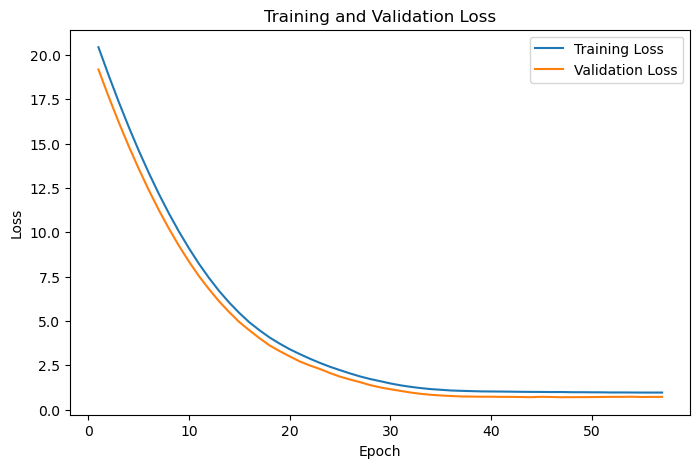

In [7]:
# Save the model
model.save('Model_Outputs/SSC_Model.h5')

# Extracting the loss values for plotting
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(train_loss) + 1)  # Update epoch range based on the actual number of epochs run

# Plotting the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Model Evaluation

After training our Convolutional Neural Network-Long Short Term Memory (CNN-LSTM) model, it is essential to assess its performance to understand how well it has learned from the training dataset and to evaluate its ability to generalize to unseen data. This step involves calculating loss and accuracy metrics on both the validation and test datasets.

### Validation Set Evaluation

In [8]:
# Evaluate the model on the validation set
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss (MSE): {val_loss:.4f}")

# Generate predictions for the validation set
val_predictions = model.predict(X_val, verbose=0)

# Calculate Mean Absolute Error (MAE) on the validation set
val_mae = mean_absolute_error(y_val.reshape(-1, y_val.shape[-1]), val_predictions.reshape(-1, val_predictions.shape[-1]))
print(f"Validation MAE: {val_mae:.4f}")

Validation Loss (MSE): 0.6944
Validation MAE: 0.3036


### Test Set Evaluation

In [9]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")

# Generate predictions for the test set
test_predictions = model.predict(X_test, verbose=0)

# Calculate Mean Absolute Error (MAE) on the test set
test_mae = mean_absolute_error(y_test.reshape(-1, y_test.shape[-1]), test_predictions.reshape(-1, test_predictions.shape[-1]))
print(f"Test MAE: {test_mae:.4f}")

Test Loss (MSE): 0.9250
Test MAE: 0.4183


### Visualizing Predictions

Plots for Validation Set:


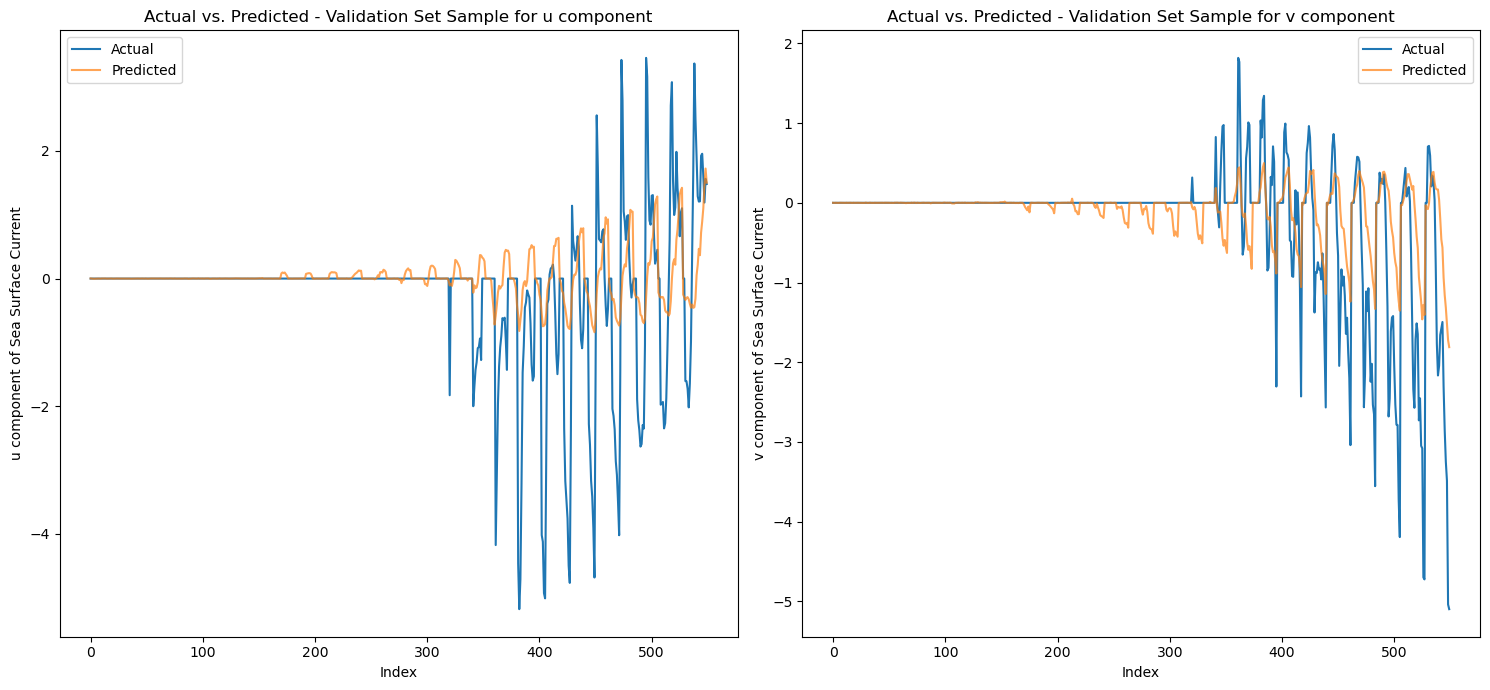

Plots for Test Set:


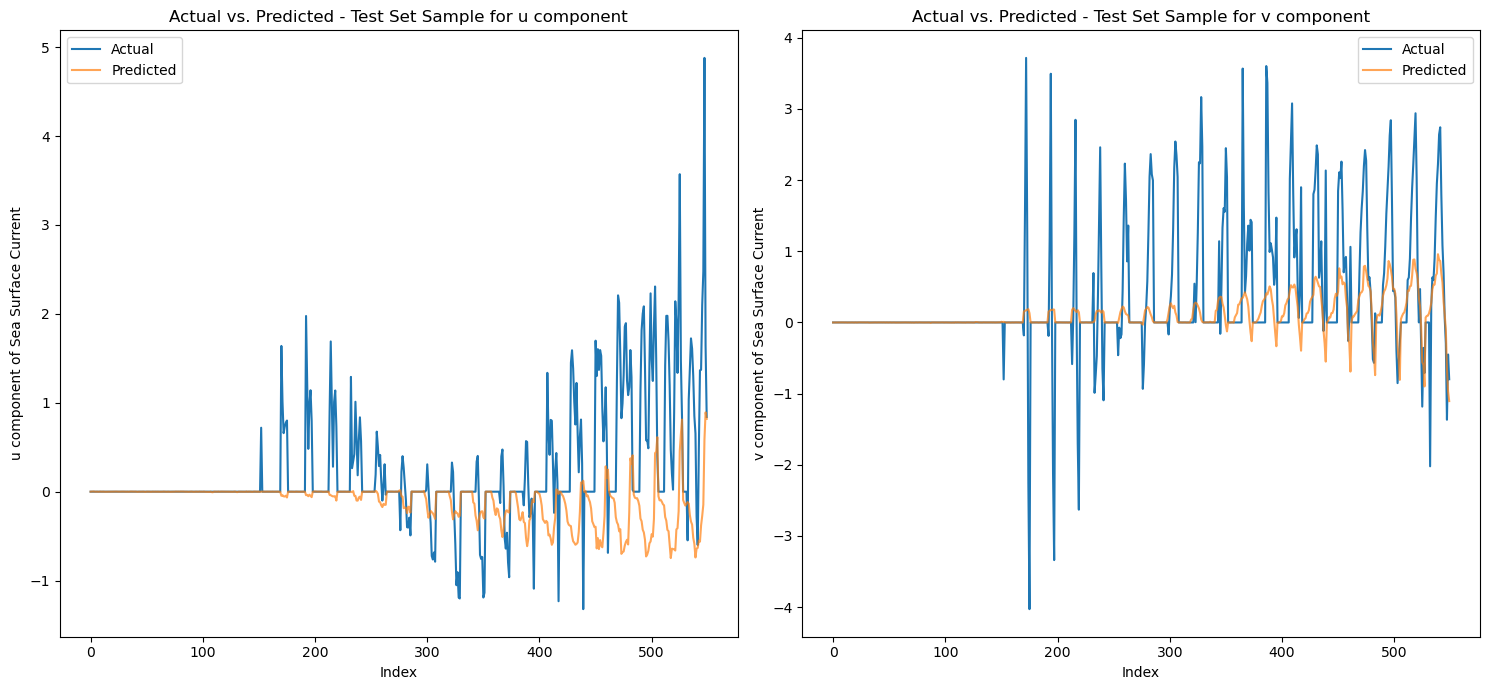

In [10]:
print("Plots for Validation Set:")

# Example: Visualizing the Actual vs. Predicted 'u' and 'v' components for the first sample in the validation set
plt.figure(figsize=(15, 7))

# Plot 'u' component
plt.subplot(1, 2, 1)
plt.plot(y_val[0, :, :, 0].flatten(), label='Actual')
plt.plot(val_predictions[0, :, :, 0].flatten(), label='Predicted', alpha=0.7)
plt.title('Actual vs. Predicted - Validation Set Sample for u component')
plt.xlabel('Index')
plt.ylabel('u component of Sea Surface Current')
plt.legend()

# Plot 'v' component
plt.subplot(1, 2, 2)
plt.plot(y_val[0, :, :, 1].flatten(), label='Actual')
plt.plot(val_predictions[0, :, :, 1].flatten(), label='Predicted', alpha=0.7)
plt.title('Actual vs. Predicted - Validation Set Sample for v component')
plt.xlabel('Index')
plt.ylabel('v component of Sea Surface Current')
plt.legend()

plt.tight_layout()
plt.show()

print("="*125)
print("Plots for Test Set:")

# Example: Visualizing the Actual vs. Predicted 'u' component for the first sample in the test set
plt.figure(figsize=(15, 7))

# Plot 'u' component
plt.subplot(1, 2, 1)
plt.plot(y_test[0, :, :, 0].flatten(), label='Actual')
plt.plot(test_predictions[0, :, :, 0].flatten(), label='Predicted', alpha=0.7)
plt.title('Actual vs. Predicted - Test Set Sample for u component')
plt.xlabel('Index')
plt.ylabel('u component of Sea Surface Current')
plt.legend()

# Plot 'v' component
plt.subplot(1, 2, 2)
plt.plot(y_test[0, :, :, 1].flatten(), label='Actual')
plt.plot(test_predictions[0, :, :, 1].flatten(), label='Predicted', alpha=0.7)
plt.title('Actual vs. Predicted - Test Set Sample for v component')
plt.xlabel('Index')
plt.ylabel('v component of Sea Surface Current')
plt.legend()

plt.tight_layout()
plt.show()

print("="*125)

### Exporting Predictions

In [11]:
# Use the last sequence from the test set as the starting point for rolling predictions
X_initial = X_test[-1]

# Collect predictions in a list
predictions = []

for step in range(56):  # 28 days * 2 predictions per day
    # Make a prediction for the next 12 hours
    next_prediction = model.predict(X_initial.reshape(1, 28, 25, 22, 2), verbose=0)
    
    # Store the prediction
    predictions.append(next_prediction[0])  # next_prediction[0] to get the single prediction from batch
    
    # Update the current sequence with the new prediction
    X_initial = np.roll(X_initial, -1, axis=0)
    X_initial[-1] = next_prediction[0]  # Update with the predicted values for the next time step

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Extract coordinates from the original dataset
time_data = ssc_ds.coords['time'][-len(predictions):].values
lat_data = ssc_ds.coords['lat'].values
lon_data = ssc_ds.coords['lon'].values

# Create a new xarray Dataset
predicted_dataset = xr.Dataset(
    {
        "u": (["time", "lat", "lon"], predictions[:, :, :, 0]),
        "v": (["time", "lat", "lon"], predictions[:, :, :, 1])
    },
    coords={
        "time": time_data,  
        "lat": lat_data,    
        "lon": lon_data     
    }
)

# Export to NetCDF
predicted_dataset.to_netcdf("Model_Outputs/predicted_ssc_data.nc")

### Simulating real life example

In [12]:
# # Use the penultimate sequence from the test set as the starting point
# X_penultimate = X_test[-2]  # The second to last sequence
# 
# # Make a prediction for the next sequence (the immediate future)
# next_sequence_prediction = model.predict(X_penultimate.reshape(1, 28, 25, 22, 2), verbose=0)
# 
# # Now compare this prediction with the actual last sequence in your test set
# actual_next_sequence = X_test[-1]  # The actual last sequence
# 
# # Calculate error metrics between predicted sequence and actual sequence
# # (You may need to reshape or adjust dimensions to match your actual data format)
# error_metrics = mean_absolute_error(actual_next_sequence.reshape(-1), next_sequence_prediction.reshape(-1))
# print(f"Error metrics for the prediction compared to the actual last sequence: {error_metrics}")
# 
# # Plot settings
# plt.figure(figsize=(15, 7))
# 
# # Plot for 'u' component
# plt.subplot(1, 2, 1)
# plt.plot(actual_next_sequence[:, :, :, 0].flatten(), label='Actual u')
# plt.plot(next_sequence_prediction[0, :, :, 0].flatten(), label='Predicted u', alpha=0.7)
# plt.title('Comparison - Actual vs. Predicted for u component')
# plt.xlabel('Index')
# plt.ylabel('u component of Sea Surface Current')
# plt.legend()
# 
# # Plot for 'v' component
# plt.subplot(1, 2, 2)
# plt.plot(actual_next_sequence[:, :, :, 1].flatten(), label='Actual v')
# plt.plot(next_sequence_prediction[0, :, :, 1].flatten(), label='Predicted v', alpha=0.7)
# plt.title('Comparison - Actual vs. Predicted for v component')
# plt.xlabel('Index')
# plt.ylabel('v component of Sea Surface Current')
# plt.legend()
# 
# plt.show()